# Setup

In [1]:
# check GPU
!nvidia-smi

Sat Jan 14 17:31:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout resnet_perm_spec

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 961, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 961 (delta 97), reused 104 (delta 87), pack-reused 790
Receiving objects: 100% (961/961), 37.54 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (575/575), done.
Branch 'resnet_perm_spec' set up to track remote branch 'resnet_perm_spec' from 'origin'.
Switched to a new branch 'resnet_perm_spec'


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.training import *
from mode_connectivity.lmc import *
from mode_connectivity.training_config import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.vgg import VGG
from mode_connectivity.models.resnet import ResNet

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils

import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# VGG LMC

In [5]:
# pull the required model files
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm2_a.pt 
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm2_b.pt
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm2_b_permuted.pt

Git LFS: (1 of 1 files) 4.16 MB / 4.16 MB
Git LFS: (1 of 1 files) 4.16 MB / 4.16 MB
Git LFS: (1 of 1 files) 4.16 MB / 4.16 MB


In [6]:
wm=2

# Now we generate the contour plot
a_params = torch.load(f"mode_connectivity/model_files/resnet_wm{wm}_a.pt") 
b_params = torch.load(f"mode_connectivity/model_files/resnet_wm{wm}_b.pt") 
permuted_params = torch.load(f"mode_connectivity/model_files/resnet_wm{wm}_b_permuted.pt") 
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(p) for p in [a_params, b_params, permuted_params]
)

model_a = ResNet(width_multiplier=wm)
model_a.load_state_dict(a_params)

contour_plane = utils.generate_orthogonal_basis(v1, v2, v3)
train_loader, test_loader = data.get_data_loaders(
    dataset="cifar10", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)
device, _ = get_device()
(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, contour_plane, granularity=10, return_train=False,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


11it [05:36, 30.55s/it]


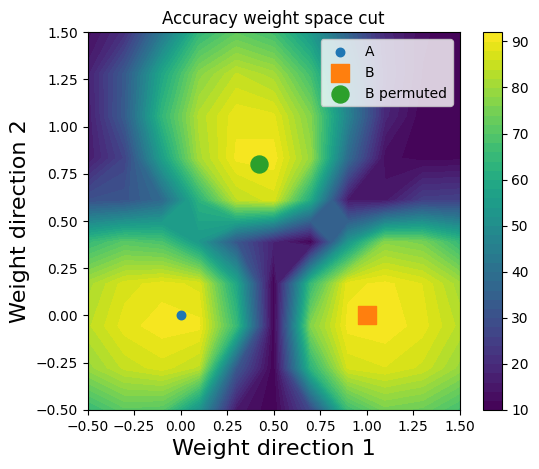

In [7]:
plot.plot_metric_contour(
    "accuracy",
    t1s,
    t2s,
    test_acc_grid,
    model_vectors_dict={
        "A": utils.projection(v1, contour_plane),
        "B": utils.projection(v2, contour_plane),
        "B permuted": utils.projection(v3, contour_plane),
    },
)

In [8]:
np.save(f'resnet_wm{wm}_test_acc_grid.npy', test_acc_grid)
np.save(f'resnet_wm{wm}_test_loss_grid.npy', test_loss_grid)